In [1]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
from scipy.stats import gaussian_kde
from scipy.stats.distributions import uniform
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from arff2pandas import a2p

from sklearn import preprocessing, tree, pipeline
from sklearn import pipeline 
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
#import ConfigSpace
import importlib

init_notebook_mode(connected=True)

In [38]:
# Creating an alternate Guassian KDE function

class alt_gauss(gaussian_kde):
    
    def rvs(self, size = 1, random_state = None):
        res = self.resample(size)
        res = res[res>=0]
        res = res.reshape(-1,1)
        
        return res

    
# Creating a class to create log uniform distributions
    
class loguni():
    def __init__(self, low, high, base = 10):
        self.low = low
        self.high = high
        self.base = base
        
    def rvs(self, size = 1, random_state = None):
        #def rvs(self, num = 1, random_state = None):
        temp = np.power(self.base, np.random.uniform(self.low, self.high, size))
        #res = self.sample(num)
        res = temp
        #res = res[res>=0]
        res = res.reshape(-1,1)

        return res
  
# Defining a log histogram plot

import matplotlib.pyplot as plt


def plot_log_hist(x, bins = 50, show_linear = False, title = '', x_lab='',y_lab =''):
    
    #x = sigmoid_df['svc__gamma@NUMERIC']
    x = np.array(x)

    #x

    # histogram on linear scale
    if show_linear:
        plt.subplot(211)
    
    hist, bins, _ = plt.hist(x, bins=bins)

    # histogram on log scale. 
    # Use non-equal bin sizes, such that they look equal on log scale.
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    #plt.subplot(211)
    #plt.hist(y, bins=logbins)
    plt.xscale('log')
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()


In [39]:
# Read data
with open('results__2000__svc__predictive_accuracy.arff') as f:
    df = a2p.load(f)
    #print(ds)
    

# Rename all the columns without the @ thing
df = df.rename(columns={col: col.split('@')[0] for col in df.columns})


# Sorting all rows by first task id and then performance for each task
df = df.sort_values(by = ['task_id','predictive_accuracy'], ascending=False)


# Casting task_id to type int
df['task_id'] = df['task_id'].astype('int64')


# dropping max iter parameter because it is constant:
df = df[['columntransformer__numeric__imputer__strategy', 'predictive_accuracy',
       'svc__C', 'svc__coef0', 'svc__degree', 'svc__gamma', 'svc__kernel',
        'svc__shrinking', 'svc__tol', 'task_id']]



In [40]:
# Getting top 500 performance rows
top = 500
filtered_df = df.groupby(['task_id']).head(top)


# Filtering out sigmoid and rbf
sigmoid_df = filtered_df[filtered_df['svc__kernel'] == 'sigmoid']
rbf_df = filtered_df[filtered_df['svc__kernel'] == 'rbf']

# Fitting KDEs for Gamma parameter
gamma_sig = alt_gauss(sigmoid_df['svc__gamma'].values, bw_method=1e-07)
gamma_rbf = alt_gauss(rbf_df['svc__gamma'], bw_method=1e-07)

# Fitting KDEs for C parameter
C_sig = alt_gauss(sigmoid_df['svc__C'].values, bw_method=1e-06)
C_rbf = alt_gauss(rbf_df['svc__C'].values, bw_method=1e-06)



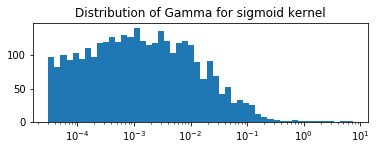

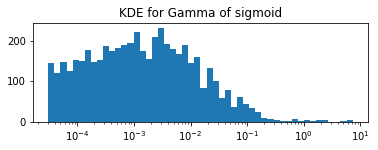

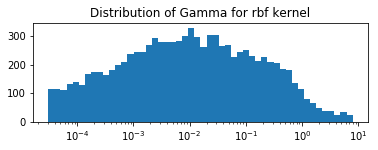

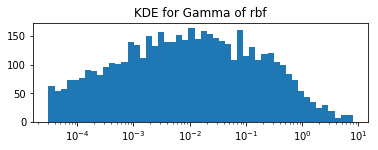

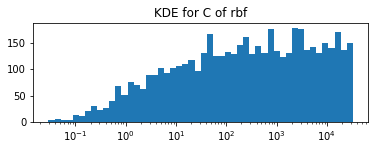

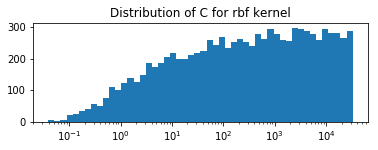

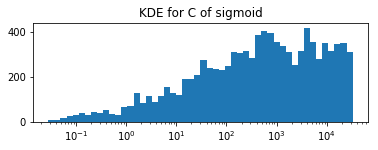

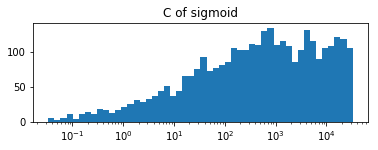

In [41]:
plot_log_hist(sigmoid_df['svc__gamma'], title='Distribution of Gamma for sigmoid kernel')
plot_log_hist(gamma_sig.rvs(5000), title='KDE for Gamma of sigmoid')
plot_log_hist(rbf_df['svc__gamma'], title='Distribution of Gamma for rbf kernel')
plot_log_hist(gamma_rbf.rvs(5000), title='KDE for Gamma of rbf')
plot_log_hist(C_rbf.rvs(5000), title='KDE for C of rbf')
plot_log_hist(rbf_df['svc__C'], title='Distribution of C for rbf kernel')
plot_log_hist(C_sig.rvs(10000), title='KDE for C of sigmoid')
plot_log_hist(sigmoid_df['svc__C'], title='C of sigmoid')

In [42]:
import warnings
warnings.filterwarnings("ignore") 


import openml
#import arff
from sklearn import preprocessing, tree, pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import VarianceThreshold
#import ConfigSpace
import importlib





In [43]:
import warnings
warnings.filterwarnings("ignore") 

task = openml.tasks.get_task(31)

dataset = task.get_X_and_y()

X = dataset[0]
y = dataset[1]





nominal_indices = task.get_dataset().get_features_by_type('nominal', [task.target_name])

numeric_indices = task.get_dataset().get_features_by_type('numeric', [task.target_name])

numeric_transformer = make_pipeline(
    Imputer(),
    StandardScaler())

# note that the dataset is encoded numerically, hence we can only impute
# numeric values, even for the categorical columns. 
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=-1),
    OneHotEncoder(handle_unknown='ignore'))

transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_indices),
        ('nominal', categorical_transformer, nominal_indices)],
    remainder='passthrough')



clf = make_pipeline(transformer, VarianceThreshold(), SVC())


kde = uniform(loc=1, scale = 10)


param_dist_kernel = {
    'svc__gamma' : gamma_sig,
    'svc__C'     : C_sig,
    'svc__kernel': ['sigmoid']
}

param_dist_uniform = {
    'svc__gamma' : loguni(low = np.log10(min(sigmoid_df['svc__gamma'])), high = np.log10(max(sigmoid_df['svc__gamma'])), base = 10) ,
    'svc__C'     : loguni(low = np.log10(min(sigmoid_df['svc__C'])), high = np.log10(max(sigmoid_df['svc__C'])), base = 10) ,
    'svc__kernel': ['sigmoid']
}




rs_kernel = RandomizedSearchCV(
    return_train_score = True,
    estimator=clf,
    cv = 4,  
    param_distributions = param_dist_kernel,
    n_iter=20
    
)

rs_uniform = RandomizedSearchCV(
    return_train_score = True,
    estimator=clf,
    cv = 4,
    param_distributions = param_dist_uniform,
    n_iter=20
    
)



#k_score = cross_val_score(X=X, y=y, cv = 4, estimator=rs_kernel)
#u_score = cross_val_score(X=X, y=y, cv = 4, estimator = rs_uniform)

#kde_score.append(np.mean(k_score))
#uni_score.append(np.mean(u_score))

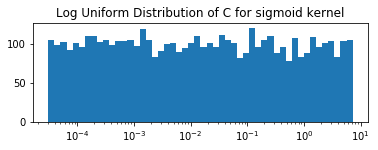

In [47]:
plot_log_hist(loguni(low = np.log10(min(sigmoid_df['svc__gamma'])), high = np.log10(max(sigmoid_df['svc__gamma'])), base = 10).rvs(5000),
              title='Log Uniform Distribution of C for sigmoid kernel')

In [8]:
from sklearn import __version__ as v

In [9]:
v

'0.20.2'

In [10]:
rs_kernel.fit(X,y)

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0))...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'svc__gamma': <__main__.alt_gauss object at 0x2aab1f1df588>, 'svc__C': <__main__.alt_gauss object at 0x2aab1f1df748>, 'svc__kernel': ['sigmoid']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [11]:
rs_kernel.best_params_

{'svc__C': array([[183.04518135]]),
 'svc__gamma': array([[0.00083386]]),
 'svc__kernel': 'sigmoid'}

In [12]:
rs_uniform.fit(X,y)

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0))...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'svc__gamma': <__main__.loguni object at 0x2aab1fa57be0>, 'svc__C': <__main__.loguni object at 0x2aab1f9ba780>, 'svc__kernel': ['sigmoid']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [13]:
rs_uniform.best_params_

{'svc__C': array([[141.44716857]]),
 'svc__gamma': array([[0.0010052]]),
 'svc__kernel': 'sigmoid'}

In [14]:
rs_kernel.best_index_

10

In [15]:
rs_uniform.best_index_

14

In [16]:
rs_kernel.best_score_

0.77

In [17]:
rs_uniform.best_score_

0.77

In [18]:
df.task_id.unique()

array([3567, 3561, 3560, 3549, 3543, 3512, 3510, 3494, 3493, 3492, 3485,
       3481, 3022, 3021, 2079, 2074,  219,   58,   53,   49,   45,   43,
         41,   37,   36,   32,   31,   29,   28,   24,   23,   22,   21,
         20,   18,   16,   15,   14,   12,   11,    6,    3])

In [25]:
k_i = rs_kernel.best_index_
k_s = rs_kernel.best_score_

u_i = rs_uniform.best_index_
u_s = rs_uniform.best_score_

k = {"index_diff" : k_i - u_i, "perf_diff" : k_s - u_s, 'uni': rs_uniform, 'kern': rs_kernel.cv_results_}
#pickling the saved object
import pickle

#your_data = {'foo': 'bar'}

# Store data (serialize)
fil_nam = 'kde_v_uni_'+ str(task_id)+'.pickle' 
with open(fil_nam, 'wb') as handle:
    pickle.dump(k, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
from sklearn.impute import SimpleImputer


In [49]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import numpy as np

def plot_hist(x, title = '', 
              xlabel = '', 
              y_label = '', 
              start = None,
              size = None, 
              end = None):
    trace1 = go.Histogram(
        x=x,
        histnorm='percent',
        name='control',
        xbins=dict(
            start=start,
            end=end,
            size=size
        ),
        marker=dict(
            color='#FFD7E9',
        ),
        opacity=0.75
    )
    
    data = [trace1]

    layout = go.Layout(
        title=title,
        xaxis=dict(
            title=xlabel
        ),
        yaxis=dict(
            title=y_label
        ),
        bargap=0.2,
        bargroupgap=0.1
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='styled histogram')

In [50]:
plot_hist(x =)


SyntaxError: invalid syntax (<ipython-input-50-db7727b86d44>, line 1)